<a href="https://colab.research.google.com/github/clarkphd/LumaTik_final/blob/main/acousticenvnew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Statements


In [1]:
!pip install stable-baselines3[extra]

from time import sleep
import gym
from gym import spaces 
import numpy as np 
import matplotlib.pyplot as plt

!pip install pyram pyrr

from pyram.PyRAM import PyRAM
from pyram.PyRAMmp import PyRAMmp
from scipy.interpolate import interpn
from itertools import product, chain
import pyrr
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate.interpolate import RegularGridInterpolator
import matplotlib.animation as animation
import multiprocessing as mp

from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env 
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback



class AcousticSearchEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, move_length):
    super(AcousticSearchEnv, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
    self.action_space = spaces.Discrete(4)
    
    #here we will use forwards back etc.. 
    high = np.array(
            [
               1,1
            ],
            dtype=np.float32,
        )
    # observation space, current position + signal
    self.observation_space =spaces.Box(-high, high, dtype=np.float32) #scale everything relative to a 0-1 observation area
    self.action_space = spaces.Discrete(5) #set action space to be 4 directions  + stationary 
    #set the move length 

    self.move_length = move_length


  def _take_action(self,action):
    if action <1:
      
      pass
    elif action<2:
      #move forward 
      self.x+=self.move_length
    elif action<3:
      #move back
      self.x-=self.move_length
    elif action<4:
      #move left
      self.y-= self.move_length
    
    elif action<5:
      #move right
      self.y+= self.move_length

    



    



  def _next_observation(self):
    obs = np.array([self.x,self.y])
    return obs


  def step(self, action):
    self._take_action(action)
    self.current_step += 1

    reward = float(- (self.x - self.target_x)**2 -  (self.y - self.target_y)**2)
    obs = self._next_observation()
    x_done = abs(self.x - self.target_x) <= self.move_length 
    y_done = abs(self.y - self.target_y) <= self.move_length 

    done = bool(x_done and y_done)

    #set max steps
    if self.current_step > 100:
      done = True
    return obs, reward, done, {}
    # Execute one time step within the environment
    ...
  def reset(self):
    self.x =  0
    self.y = 0
    self.current_step = 0

    #target starts at random point
    #self.target_x = np.random.random(size=1)
    #self.target_y = np.random.random(size=1)

    #target starts at top right
    self.target_x = 1
    self.target_y = -1

    return self._next_observation()

    # Reset the state of the environment to an initial state
    ...
  def render(self, mode='human', close=False):

    plt.scatter(self.x,self.y, label ='agent')
    plt.scatter(self.target_x,self.target_y, label = 'target')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.show(block=False)
   





Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Target + Acoustics

In [2]:

class Target:

    '''
    class for target simulation:


        INIT
        freq: charactieric target frequency Hz
        source_level: typical source level dB re ### FILL IN RE 
        min_depth: shallowest depth (m) target comes to 
        max_depth: deepest depth (m) target goes to 
        max_v: maximum velocity



    '''
    def __init__(self, freq = 50, source_level = 190, min_depth = 1, max_depth = 5000, max_v = 1):
        self.frequency = freq
        self.source_level = source_level
        self.min_depth = min_depth
        self.max_depth = max_depth
        self.max_v = max_v
        self.loc = np.array([0,0,(self.min_depth+self.max_depth)/2])
        pass
    

    def change_start_pos(self,x,y,z):
        '''set the new location for the Target in cartesian x,y,z coordinates (similar to UTM)'''
        if self.min_depth < z < self.max_depth:
            self.loc = np.array([x,y,z])
        else:
            print ('invalid depth')
            pass 


    def random_path(self, time = 20, output_interval = 1, step = 1, constant_v = False):
        '''
        Return random path within the max v with random accelaration starting from (0,0,middle depth)
        poll rate is in Hz for output, velocigy is drawn from uniform distribution

        returns (times,positions(x,y,z))
  
        '''



        #set start lcoation if not given
        current = self.loc

        
        
        #set current time
        tn = 0
        times = []
        locations = []
        times.append(tn)
        locations.append(current)

        #add locations from normal ditribution
        while tn<time:

            #draw headings from a normal distribution 
            heading = np.array((np.random.normal(0,0.5),np.random.normal(0,0.5),np.random.normal(0,0.5))) 
            heading = heading/np.linalg.norm(heading) #normalise heading to unity
            if constant_v:
                current_new = current + self.max_v*step * heading
            else:
                current_new = current + np.random.uniform(0,self.max_v)*step * heading # update position dependant on time and uniformly selected speed
            

            ### CORRECT FOR DEPTH LIMITS ####
            while  self.max_depth < current_new[-1] or current_new[-1] < self.min_depth:

                #heading = np.array((np.random.uniform(-1,1),np.random.uniform(-1,1),np.random.uniform(-1,1)))
                #heading = np.array((np.random.uniform(-0.2,1),np.random.uniform(-0.2,1),np.random.uniform(-1,1)))
                heading = np.array((np.random.normal(0,0.5),np.random.normal(0,0.5),np.random.normal(0,0.5)))
                heading = heading/np.linalg.norm(heading) #normalise heading to 
                current_new = current + np.random.uniform(0,self.max_v)*step * heading

            current = current_new

            if tn%output_interval ==0:
                locations.append(current)
                times.append(tn)
            tn = tn+ step
        return (np.array(times),  np.array(locations))


def interpolate_slice(results,in_points,out_points,slice):
    values = list(chain.from_iterable([run.results['TL Grid'][slice,:] for run in results]))
    interpolator = LinearNDInterpolator(in_points,values)
    return interpolator(out_points)



class Receiver:

    '''
    class for reciever simulation:


        INIT
 
        min_depth: shallowest depth (m) target comes to 
        max_depth: deepest depth (m) target goes to 
        max_v: maximum velocity



    '''
    def __init__(self,  min_depth = 1, max_depth = 5000, max_v = 1):
        self.min_depth = min_depth
        self.max_depth = max_depth
        self.max_v = max_v
        self.loc = np.array([0,0,self.min_depth])

        pass
    

    def change_start_pos(self,x,y,z):
        if self.min_depth < z < self.max_depth:
            self.loc = np.array([x,y,z])
        else:
            print ('invalid depth')
            pass 


class Region:
    '''Generic region class holding environmental and bathymetric data '''

    #initialise 100km default square centered domain
    def __init__(self, xmin = 0, xmax = 100000, ymin= 0,ymax = 100000):

        self.xmin= xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        pass 

    #add grid for data entry 
    def add_grid_numeric(self, no_gridpoints):
        self.xrange = np.linspace(self.xmin,self.xmax, no_gridpoints)
        self.yrange = np.linspace(self.ymin,self.ymax, no_gridpoints)
        self.xi , self.yi = np.meshgrid(self.xrange,self.yrange)
    
    def add_grid_metres(self, spacing):
        self.xrange = np.arange(self.xmin,self.xmax +1,spacing)
        self.yrange = np.arange(self.ymin,self.ymax +1,spacing)
        self.xi , self.yi = np.meshgrid(self.xrange,self.yrange)

    def add_flat_bathy(self, depth):
        #add a set depth across entire domain
        try:
            self.bathy = np.ones_like(self.xi) * depth
        except AttributeError as err:
            print ('Grid Not found define either metre or numeric grid before calling bathy', err)
    
    def random_transect(self,spacing):

        #genenerate a set of random evenly spaced points between two edges

        x1 = np.random.uniform(self.xmin,self.xmax)
        x2 = np.random.uniform(self.xmin,self.xmax)

        y1 = np.random.uniform(self.ymin,self.ymax)
        y2 = np.random.uniform(self.ymin,self.ymax)

        z1 = np.random.uniform(self.bathy.min(),0)
        z2 = np.random.uniform(self.bathy.min(),0)

        state = np.random.randint(6)
        if state==0:
            start = np.array([self.xmin,y1,z1])
            end = np.array([self.xmax,y2,z2])
        
        elif state==1:
            start = np.array([x1,self.ymin,z1])
            end = np.array([x2,self.ymax,z2])
        
        elif state==2:
            start = np.array([self.xmin,y1,z1])
            end = np.array([x2,self.ymax,z2])

        elif state==3:
            start = np.array([x1,self.ymin,z1])
            end = np.array([self.xmin,y2,z2])
        
        elif state==4:
            start = np.array([self.xmax,y1,z1])
            end = np.array([x2,self.ymax,z2])

        elif state==5:
            start = np.array([x1,self.ymin,z1])
            end = np.array([self.xmax,y2,z2])

        
        distance = np.linalg.norm(start-end)
        count = int(distance/spacing)
        x_vals = np.linspace(start[0],end[0],count)
        y_vals = np.linspace(start[1],end[1],count)
        z_vals = np.linspace(start[2],end[2],count)

        return x_vals,y_vals,z_vals
        

        
    











    def add_function_bathy(self, function, scale = 1):
        #add a functional variation over a function F(0,1) in 2D , must call flat bathy fist to set offset

        try:
            self.bathy 

        except AttributeError as err:
            print ('flat bathy not found define using add flat bathy', err)
        
        function_x = np.linspace(0,1,len(self.xrange))
        function_y = np.linspace(0,1,len(self.yrange))
        function_mesh_x, function_mesh_y = np.meshgrid(function_x,function_y)

        self.bathy = self.bathy + scale*function(function_mesh_x,function_mesh_y)
        self.bathy_interpolator = RegularGridInterpolator((self.xrange,self.yrange),self.bathy)


        

        
        
    def plot_bathy(self):

        plt.imshow(-np.rot90(self.bathy), extent=[self.xmin/1000,self.xmax/1000,self.ymin/1000,self.ymax/1000], cmap = 'viridis')
        plt.xlabel('x distance km')
        plt.ylabel('y distance km')
        plt.colorbar(orientation = 'horizontal', label = 'Depth m')
        
    
    def add_iso_velocity(self, c0 = 1600, vspace = 10):
        self.vrange = np.arange(0,self.bathy.max(),vspace)
        self.ss = np.ones((len(self.xrange),len(self.yrange), len(self.vrange))) * c0
    

    def add_channel_velocity(self,c0= 1500,z0 = 1000 ,mu = 0.0071, h = 1200, vspace= 10):

        '''
        add canonical channel sound speed profile, 
        c0: ref sound speed
        z0: channel depth
        mu: ?
        h: channel height
        '''
        self.vrange = np.arange(0,self.bathy.max() + 5*vspace,vspace)
        nu = (2/h) * (self.vrange-z0)
        single_line = c0*(1 + mu*(nu + np.exp(-nu)-1))
        self.ss = np.broadcast_to(single_line, (len(self.xrange), len(self.yrange), len(self.vrange)))
    
    def plot_ss_centre(self):
        locx  = int(len(self.xrange)/2)
        locy  = int(len(self.yrange)/2)
        plt.plot(self.ss[locx,locy,:],-self.vrange)
        plt.xlabel('sound speed m/s')
        plt.ylabel('depth')




class depth_range_pyram():

    def __init__(self,Receiver,Target,Region):
        


        ### check reciver and target within region ####
        r_valid = (Region.xmin -1 <= Receiver.loc[0] <= Region.xmax +1) and (Region.ymin -1 <= Receiver.loc[1] <= Region.ymax +1)
        t_valid = (Region.xmin -1 <= Target.loc[0] <= Region.xmax +1) and (Region.ymin -1 <= Target.loc[1] <= Region.ymax +1)

        if r_valid and t_valid:
            self.Receiver = Receiver
            self.Target = Target
        else:
            raise ValueError 
        
    
    def setup_run(self, Region,bathy_res = 100, ss_res = 100, c0 = 1500, id = 1):


        #interpolate bathymetry and sound speed to line across domain

        vector_dist = self.Receiver.loc[:2]- self.Target.loc[:2] 
        distance = np.linalg.norm(vector_dist)
        self.distance = distance

        #set bathymetry interpolation points 
        bathy_points = int(distance / bathy_res)
        bathy_x = np.linspace(self.Target.loc[0],self.Receiver.loc[0],bathy_points)
        bathy_y = np.linspace(self.Target.loc[1],self.Receiver.loc[1],bathy_points)

        #set sound speed interpolation points 
        ss_points = int( distance / ss_res)
        ss_x = np.linspace(self.Target.loc[0],self.Receiver.loc[0],ss_points)
        ss_y = np.linspace(self.Target.loc[1],self.Receiver.loc[1],ss_points)

        line_bathymetry = interpn((Region.xrange,Region.yrange), Region.bathy, (bathy_x,bathy_y))

        #make a list of sound speed points vertically
        ss_xy = list(zip(*(ss_x,ss_y)))
 
        points = list(product(ss_xy,Region.vrange)) #spread across 2D domain
        points = [(i[0][0],i[0][1],i[-1]) for i in points]

        line_ss= interpn((Region.xrange,Region.yrange, Region.vrange), Region.ss, points)
        line_ss = np.rot90(line_ss.reshape((len(ss_xy),len(Region.vrange))))

        #set default parameters
        wavelength = c0 / self.Target.frequency
        vert_calc_res = wavelength / 8
        range_calc_res = wavelength * 5
        plot_depth = 1.1 * Region.bathy.max()

        self.pyram_kwargs = dict(dz = vert_calc_res,dr = range_calc_res, zmplt= plot_depth, 
                                        c0=c0, np = 10, id = id, rmax = distance)

        self.pyram_args = dict(freq= self.Target.frequency,
                                    zs=self.Target.loc[-1],
                                    zr=self.Receiver.loc[-1],
                                    z_ss= Region.vrange,
                                    rp_ss=np.linspace(0,distance,len(ss_xy)),
                                    cw=line_ss,
                                    z_sb=np.array([0.]),
                                    rp_sb=np.array([0.]),
                                    cb=np.array([[1495]]),
                                    rhob=np.array([[1.145]]), #set bottom density (to be updated with BDT data)
                                    attn=np.array([[0.3]]),
                                    rbzb= np.array(list(zip(np.linspace(0,distance,len(line_bathymetry)),line_bathymetry))))

        
        
        
        
    def run_pyram(self):

        if self.pyram_args['rbzb'].ndim == 1:
            self.results = {'TL Line': [0,0]}

        else:
            pyram = PyRAM(self.pyram_args['freq'], self.pyram_args['zs'],
                        self.pyram_args['zr'], self.pyram_args['z_ss'],
                        self.pyram_args['rp_ss'], self.pyram_args['cw'],
                        self.pyram_args['z_sb'], self.pyram_args['rp_sb'],
                        self.pyram_args['cb'], self.pyram_args['rhob'],
                        self.pyram_args['attn'], self.pyram_args['rbzb'],
                        **self.pyram_kwargs)

            self.results = pyram.run()

    
    def plot_single_run(self, skip_in = True):

        if skip_in:
            skip_in = int(len(self.results['Ranges'])/15)
        #if skip set ranges to clip 
    
        plt.imshow(-self.results['TL Grid'][:,skip_in:], extent = (self.results['Ranges'][skip_in], self.results['Ranges'][-1],  self.results['Depths'][-1],  self.results['Depths'][0]), aspect=10 )
        plt.colorbar(orientation = 'horizontal')

    def get_reciever_TL(self):
        try:
          tl = self.results['TL Line'][-1]
        except:
          tl = 1000 #return high tl where there is no result

        return tl
        
        
class cylinder_pyram():

    '''Class for defining a cyclindrical coordinate 2D solution to the transmission loss from a single point source'''
    def __init__(self,Receiver,Target,Region,theta):
        self.Region = Region

        ### check reciver within region ####
        r_valid = (Region.xmin-1 <= Receiver.loc[0] <= Region.xmax +1) and (Region.ymin -1 <= Receiver.loc[1] <= Region.ymax +1)
        if r_valid and 0 < theta < 180 :
            self.Receiver = Receiver
            self.Target = Target
            self.theta = np.radians(theta)
        else:
            raise ValueError 
        
        self.thetas = np.arange(0,2*np.pi,self.theta)
        directions = [np.array([np.cos(angle), np.sin(angle)]) for angle in self.thetas]


        #define axis aligned box and rays
        aabb = np.array([[self.Region.xmin,self.Region.ymin,0], [self.Region.xmax,self.Region.ymax,0]])
        rays = [ np.array([[self.Target.loc[0],self.Target.loc[1],0], [direction[0],direction[1],0]]) for direction in directions]

        intersections = []
        for ray in rays:
            intersection =pyrr.geometric_tests.ray_intersect_aabb( ray, aabb )
            intersections.append([int(intersection[0]), int(intersection[1])]) #round to the nearest metre 
        self.intersections = np.array(intersections)
    
    def plot_geometry(self):

        plt.scatter(self.intersections[:,0],self.intersections[:,1],c = 'r')
        plt.scatter(self.Target.loc[0], self.Target.loc[1], c = 'Grey')
        plt.gca().set_aspect('equal')
        
    
    def plot_geom_bathy(self):
        
        self.plot_geometry()
        self.Region.plot_bathy()

    
    def run_cylinder(self, multi = False):
        print ('start point run')
        '''Run input arguments for a single point source radially'''

        if multi:
            #run loop if multiprocessing selected
            runs = []
            count = 0
            self.all_results = []
            #loop over each end point and add to the run loop
            for end_point in self.intersections:
  
                self.Receiver.change_start_pos(end_point[0],end_point[1],self.Receiver.loc[-1])
                loop_run = depth_range_pyram(self.Receiver, self.Target, self.Region)
                loop_run.setup_run(self.Region, id=count)
                runs.append((loop_run.pyram_args,loop_run.pyram_kwargs))
                self.all_results.append(loop_run)

                count+=1
            
            pyram_mp =  PyRAMmp()
            nproc = pyram_mp.pool._processes
            print ('submit')
            pyram_mp.submit_runs(runs)
            print ('ran \n \n ')

            results = [None] * len(self.intersections)
            for result in pyram_mp.results:
                rid = result['ID']
                results[rid] = result
            pyram_mp.close()

            for i, loop in enumerate(self.all_results):
                loop.results = results[i]

            

            
    
                
        #single core run 
        else:
            print ('not multi')
            all_results = []
            for end_point in self.intersections:
                print (self.Receiver.loc[-1])
                self.Receiver.change_start_pos(end_point[0],end_point[1],self.Receiver.loc[-1])
                loop_run = depth_range_pyram(self.Receiver, self.Target, self.Region)
                loop_run.setup_run(self.Region)
                loop_run.run_pyram()
                all_results.append(loop_run)
            
            self.all_results = all_results
    
    def interpolate_slices(self, xy_res, pos = None, multi = False):

        x_points = int( (self.Region.xmax - self.Region.xmin ) / xy_res)
        y_points = int( (self.Region.ymax - self.Region.ymin ) / xy_res)
        res_x = np.linspace(self.Region.xmin,self.Region.xmax,x_points)
        res_y = np.linspace(self.Region.ymin,self.Region.ymax,y_points)

        out_points = list(product(res_x,res_y))
        in_points = []

        #enable parsing of a new point to interpolate from is self.Target has been updated externally 
        if pos is None:
            loc = self.Target.loc
        else:
            loc = pos

        for i,run in enumerate(self.all_results):
            x = loc[0] + (run.results['Ranges'] * np.cos(self.thetas[i]))
            y = loc[1] +  (run.results['Ranges'] * np.sin(self.thetas[i]))

            in_points.append(list(zip(*(x,y))))
        in_points = list(chain.from_iterable(in_points))      
        res_v = self.all_results[0].results['Depths']
        self.res_y = res_y
        self.res_v = res_v
        self.interp_results = np.zeros((len(res_x),len(res_y),len(res_v)))

        if multi:
            pool = mp.Pool(mp.cpu_count())
            print ('start interp')
            results = [pool.apply(interpolate_slice, args=(self.all_results, in_points,out_points,depth_slice)) for depth_slice in range(len(res_v))]
            pool.close() 
            print ('worked')
        else:
            print ('start interp')
            for depth_slice in range(len(res_v)):
                values = list(chain.from_iterable([run.results['TL Grid'][depth_slice,:] for run in self.all_results]))
                interpolator = LinearNDInterpolator(in_points,values)
                self.interp_results[:,:,depth_slice] = interpolator(out_points).reshape(x_points,y_points)
        


        

    
    def plot_TL_slice(self,slice,offset = 0):

        plt.imshow(np.rot90(self.interp_results[:,:,slice]), extent=[self.Region.xmin/1000,self.Region.xmax/1000,self.Region.ymin/1000,self.Region.ymax/1000], cmap = 'viridis_r')
        plt.xlabel('x distance km')
        plt.ylabel('y distance km')
        plt.colorbar(orientation = 'horizontal', label = 'TL dB re 1m')
        plt.title(f'Transmission loss depth = {self.res_v[slice]}')
        pass

        
    def plot_TL_slice_x(self,slice):

        plt.imshow(np.rot90(self.interp_results[:,slice,:]), extent=[self.Region.xmin/1000,self.Region.xmax/1000,self.Region.bathy.max()/1000,0], cmap = 'viridis_r')
        plt.xlabel('x distance km')
        plt.ylabel('Depth km')
        plt.colorbar(orientation = 'horizontal', label = 'TL dB re 1m')
        plt.title(f'Transmission loss y = {self.res_y[slice]}')
        pass
    
    def plot_interp_points(self):

        plt.scatter(self.in_points[:,0],self.in_points[:,1], marker = '+', label = 'Model Data')
        plt.xlabel('x distance km')
        plt.ylabel('y distance km')
    
    def plot_animation_x(self,savefile):

        #plot aimation through y axis

        frames = [] # for storing the generated images
        fig = plt.figure()
        plt.xlabel('x distance km')
        plt.ylabel('Depth km')
        for i in range(len(self.res_y)):
            frames.append([plt.imshow(np.flip(np.rot90(self.interp_results[:,i,:]), axis=0), extent=[self.Region.xmin/1000,self.Region.xmax/1000,self.Region.bathy.max()/1000,0],vmin = -150, vmax = -30, cmap = 'viridis_r', animated = True, aspect='auto')])

        plt.colorbar(orientation = 'horizontal', label = 'TL dB re 1m')
        ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                        repeat_delay=1000)
        ani.save(f'{savefile}.gif')
        plt.clf()
    
    def plot_animation_v(self,savefile):

        frames = [] # for storing the generated images
        fig = plt.figure()
        plt.xlabel('x distance km')
        plt.ylabel('y distance km')
        for i in range(len(self.res_v)):
            #plt.text((self.Region.xmax-self.Region.xmin)/2, (self.Region.ymax-self.Region.ymin)/2, f'Depth: {self.res_v[i]:2f}')
            frames.append([plt.imshow(np.rot90(self.interp_results[:,:,i]), extent=[self.Region.xmin/1000,self.Region.xmax/1000,self.Region.ymin/1000,self.Region.ymax/1000],vmin = -150, vmax = -30, cmap = 'viridis_r', animated = True)])

        plt.colorbar(orientation = 'horizontal', label = 'TL dB re 1m')
        circle1 = plt.Circle((self.Target.loc[0],self.Target.loc[1]), 10, color = 'r')
        plt.gca().add_patch(circle1)
        ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                        repeat_delay=1000)
        ani.save(f'{savefile}.gif')
        plt.clf()
        



        

            

        
class Grid_search:

    '''class for searching over multiple cyclinder runs'''

    def __init__(self,Receiver,Target,Region):
        self.Receiver = Receiver
        self.Target = Target
        self.Region = Region
    

    def set_xy_source_grid(self, spacing, buffer):

        '''create grid of source points spaced x meters apart'''
        depth = self.Target.loc[-1]
        x_points = int((self.Region.xmax - 2*buffer -  self.Region.xmin)/spacing)
        y_points = int((self.Region.ymax - 2*buffer -  self.Region.ymin)/spacing)

        x_range = np.linspace(self.Region.xmin+ buffer, self.Region.xmax - buffer, x_points)
        y_range = np.linspace(self.Region.ymin+ buffer, self.Region.ymax - buffer, y_points)

        self.target_points = np.array([(x,y,depth) for x in x_range for y in y_range])
    
    def set_xyz_source_grid(self, spacing, buffer):

        '''create grid of source points spaced x meters apart'''
        x_points = int((self.Region.xmax - 2*buffer -  self.Region.xmin)/spacing)
        y_points = int((self.Region.ymax - 2*buffer -  self.Region.ymin)/spacing)
        z_points = int(( self.Region.bathy.max()- 5 )/spacing)

        x_range = np.linspace(self.Region.xmin+ buffer, self.Region.xmax - buffer, x_points)
        y_range = np.linspace(self.Region.ymin+ buffer, self.Region.ymax - buffer, y_points)
        z_range = np.linspace(5, self.Region.bathy.max(), z_points)

        target_points = np.array([(x,y,z) for x in x_range for y in y_range for z in z_range])
        filter = [self.Region.bathy_interpolator((i[0],i[1])) > i[2] for i in target_points] #filter out points under sea floor
        self.target_points = target_points[filter] 
        print (len(self.target_points))

    
    
    


    def run_all_points(self, theta, multi = False):

        source_results = []

        '''run over every target location for stated theta values'''
        for location in self.target_points:

            self.Target.change_start_pos(*location)
            loop_result = cylinder_pyram(self.Receiver,self.Target,self.Region,theta=theta)
            loop_result.run_cylinder(multi=multi)
            source_results.append(loop_result)
        

        self.raw = source_results
    
    def interp_results(self,xy_res):
        x_points = int( (self.Region.xmax - self.Region.xmin ) / xy_res)
        y_points = int( (self.Region.ymax - self.Region.ymin ) / xy_res)
        v_points = len(self.raw[0].all_results[0].results['Depths'])
        self.all_results = np.zeros((len(self.target_points),x_points,y_points,v_points))

        for i,result in enumerate(self.raw):
            result.interpolate_slices(xy_res, self.target_points[i])

            self.all_results[i,:,:,:] = result.interp_results
    
    
    def source_average_TL(self):
        self.source_TL = np.nanmean(self.all_results, axis=0)
    

    def plot_source_grid(self):
        # plot xy source coordinates for a grid search 

        plt.scatter(self.target_points[:,0], self.target_points[:,1], marker = '+', c = 'r', label = 'sources')
        plt.xlim(self.Region.xmin,self.Region.xmax)
        plt.ylim(self.Region.ymin,self.Region.ymax)
        plt.xlabel('x distance km')
        plt.ylabel('y distance km')
    
    def plot_average(self,depth_slice):

        #plot the average TL loss across all sources for the volume

        average = np.nanmean(10**(self.all_results/10), axis = 0)
        plt.imshow(-np.rot90(10*np.log10(average[:,:,depth_slice])))
        plt.xlabel('x distance km')
        plt.ylabel('y distance km')
        plt.colorbar(orientation = 'horizontal', label = 'TL dB re 1m')
        plt.title(f'Transmission loss depth = {self.raw[0].res_v[depth_slice]}')
    
    def plot_animation_v(self,savefile):
        average = np.nanmean(10**(self.all_results/10), axis = 0)
        frames = [] # for storing the generated images
        fig = plt.figure()
        plt.xlabel('x distance km')
        plt.ylabel('y distance km')
        for i in range(len(self.res_v)):
            #plt.text((self.Region.xmax-self.Region.xmin)/2, (self.Region.ymax-self.Region.ymin)/2, f'Depth: {self.res_v[i]:2f}')
            frames.append([plt.imshow(-np.rot90(10*np.log10(average[:,:,i])), extent=[self.Region.xmin/1000,self.Region.xmax/1000,self.Region.ymin/1000,self.Region.ymax/1000],vmin = -150, vmax = -30, cmap = 'viridis', animated = True)])

        plt.colorbar(orientation = 'horizontal', label = 'TL dB re 1m')
        circle1 = plt.Circle((self.Target.loc[0],self.Target.loc[1]), 10, color = 'r')
        plt.gca().add_patch(circle1)
        ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                        repeat_delay=1000)
        ani.save(f'{savefile}.gif')
        plt.clf()






# Environment 4

linear penalisation 



In [3]:
class AcousticSearchEnv4(gym.Env):
  """Custom Environment that follows gym interface
  env 3 introduces the agent and acoustic environment for static targets"""
  metadata = {'render.modes': ['human']}

  def __init__(self, move_length, move_directions, TAR: Target, REC: Receiver, REG: Region, noise = 90, random = False):
    super(AcousticSearchEnv4, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
   
    
    #here we will use forwards back etc.. 
    high = np.array(
            [
               10000,10000,10000
            ],
            dtype=np.float32,
        )
    # observation space, current position + signal
    self.observation_space =spaces.Box(-high, high, dtype=np.float32) #scale everything relative to a 0-1 observation area
    self.action_space = spaces.Discrete(move_directions + 1) #set action space to be 4 directions  + stationary 
    #set the move length 

    self.move_length = move_length
    self.move_angles = np.linspace(0,2*np.pi,move_directions + 1)
    self.REC = REC
    self.TAR = TAR
    self.REG = REG
    self.rec_start_loc = REC.loc
    self.tar_start_loc = TAR.loc
    self.random = random
    self.noise_level = noise

    self.move_multiple = 1
    self.edge_max = 10 #set maximum edge penalisation



  def _take_action(self,action):
    if action <1:
      
      pass
    
    else:
      #move forward 
      x_move =  self.move_length * np.cos(self.move_angles[action-1])
      y_move =  self.move_length * np.sin(self.move_angles[action-1])
      self.REC.change_start_pos(self.REC.loc[0] + x_move,self.REC.loc[1] + y_move,self.REC.loc[-1])



    



    



  def _next_observation(self):
    obs = self.REC.loc
    return obs


  def step(self, action):
    self._take_action(action)
    self.current_step += 1
    reward = -1 #penalise each extra step
    #reward = float(- (self.x - self.target_x)**2 -  (self.y - self.target_y)**2)

    ##### simulation for reward #######
    r_valid = (self.REG.xmin-1 <= self.REC.loc[0] <= self.REG.xmax +1) and (self.REG.ymin -1 <= self.REC.loc[1] <= self.REG.ymax +1)
    if r_valid:
      simulation = depth_range_pyram(self.REC,self.TAR,self.REG)
      try:
        simulation.setup_run(self.REG)
        simulation.run_pyram()
        transmission_loss = simulation.get_reciever_TL()
        SNR = self.TAR.source_level - transmission_loss - self.noise_level #noise level 

        #### simple detection (threshold above 10dB)
        detection = SNR > 10
      except:
        detection = False

      #### set reward to high SNR for now 

      reward += int(detection) 
      x_done = abs(self.REC.loc[0] - self.TAR.loc[0]) <= self.move_length 
      y_done = abs(self.REC.loc[1] - self.TAR.loc[1]) <= self.move_length 
      done = bool(x_done and y_done)

      move_multiple = self.move_multiple
      edge_max = self.edge_max #set maximum edge penalisation

      #add edge penalisation
      if (self.REG.xmin+ move_multiple * self.move_length > self.REC.loc[0]):
        #print (self.REC.loc[0], self.REG.xmin+ move_multiple * self.move_length )
        reward -=  ((self.REC.loc[0] - self.REG.xmin) / (move_multiple * self.move_length - self.REG.xmin )) * edge_max
      elif (self.REG.ymin+ move_multiple * self.move_length > self.REC.loc[1]):
        #print (self.REC.loc[1],self.REG.ymin+ move_multiple * self.move_length )
        reward -=  ((self.REC.loc[1] - self.REG.ymin) / (move_multiple * self.move_length - self.REG.ymin )) * edge_max
      elif  self.REC.loc[0] > self.REG.xmax - move_multiple * self.move_length : 
        #print(self.REC.loc[0], self.REG.xmax - move_multiple * self.move_length)
        reward -=  (( self.REG.xmin - self.REC.loc[0] ) / (self.REG.xmin - move_multiple * self.move_length  )) * edge_max
      elif  self.REC.loc[1] > self.REG.ymax - move_multiple * self.move_length : 
        #print (self.REC.loc[1])
        reward -=  (( self.REG.ymin - self.REC.loc[1] ) / (self.REG.ymin - move_multiple * self.move_length  )) * edge_max


      


      

    else:
      reward = -100
      done = True



    obs = self._next_observation()


    #set max steps
    if self.current_step > 100:
      done = True
    return obs, reward, done, {}
    # Execute one time step within the environment
    ...
  def reset(self):

    #reset to random start location for reciever

    self.current_step = 0
    #self.REC.change_start_pos(*self.rec_start_loc)
    self.REC.change_start_pos(np.random.randint(self.REG.xmin + (self.move_multiple * self.move_length),self.REG.xmax-  (self.move_multiple * self.move_length) ),
                              np.random.randint(self.REG.ymin + (self.move_multiple * self.move_length),self.REG.ymax-  (self.move_multiple * self.move_length) ),self.rec_start_loc[-1])
    if self.random == True:
      
      self.TAR.change_start_pos(np.random.randint(self.REG.xmin + (self.move_multiple * self.move_length),self.REG.xmax-  (self.move_multiple * self.move_length) ),
                              np.random.randint(self.REG.ymin + (self.move_multiple * self.move_length),self.REG.ymax-  (self.move_multiple * self.move_length) ),self.tar_start_loc[-1])
    else:
      self.TAR.change_start_pos(*self.tar_start_loc)

    self.rec_start_loc = self.REC.loc
    self.tar_start_loc = self.TAR.loc
    #target starts at top right


    return self._next_observation()

    # Reset the state of the environment to an initial state
    ...
  def render(self, mode='human', close=False):

    plt.scatter(self.x,self.y, label ='agent')
    plt.scatter(self.target_x,self.target_y, label = 'target')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.show(block=False)
   





# Environment 5

History in observation

In [4]:
class AcousticSearchEnv5(gym.Env):
  """Custom Environment that follows gym interface
  env 3 introduces the agent and acoustic environment for static targets"""
  metadata = {'render.modes': ['human']}

  def __init__(self, move_length, move_directions, TAR: Target, REC: Receiver, REG: Region, noise = 90):
    super(AcousticSearchEnv5, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
   
    self.memory_length = 10
    #observation memory length*(dx,dy,SNR) obervation[-1] bering most 
    high = np.ones((self.memory_length,3),dtype=np.float32) * 10000

    
    
    # observation space, current position + signal
    self.observation_space =spaces.Box(-high, high, dtype=np.float32) #scale everything relative to a 0-1 observation area
    self.action_space = spaces.Discrete(move_directions + 1) #set action space to be 4 directions  + stationary 
    #set the move length 

    self.move_length = move_length
    self.move_angles = np.linspace(0,2*np.pi,move_directions + 1)
    self.REC = REC
    self.TAR = TAR
    self.REG = REG
    self.rec_start_loc = REC.loc
    self.tar_start_loc = TAR.loc

    self.noise_level = noise
    self.move_multiple = 1
    self.edge_max = 10 #set maximum edge penalisation




  def _take_action(self,action):
    if action <1:
      self.x_move =  0
      self.y_move =  0
      pass
    
    else:
      #move forward 
      self.x_move =  self.move_length * np.cos(self.move_angles[action-1])
      self.y_move =  self.move_length * np.sin(self.move_angles[action-1])
      self.REC.change_start_pos(self.REC.loc[0] + self.x_move,self.REC.loc[1] + self.y_move,self.REC.loc[-1])



    



    



  def _next_observation(self):
    #shift left and run sim for SNR 

    self.obs[:-1] = self.obs[1:]
    self.obs[-1,0] = self.x_move
    self.obs[-1,1] = self.y_move

    r_valid = (self.REG.xmin-1 <= self.REC.loc[0] <= self.REG.xmax +1) and (self.REG.ymin -1 <= self.REC.loc[1] <= self.REG.ymax +1)

    if r_valid:
      simulation = depth_range_pyram(self.REC,self.TAR,self.REG)
      try:
        simulation.setup_run(self.REG)
        simulation.run_pyram()
        transmission_loss = simulation.get_reciever_TL()
        SNR = self.TAR.source_level - transmission_loss - self.noise_level #noise level
      except Exception as e:
        print(e)
        SNR = 0 #if it fails assign no signal 
    else:
      SNR = 0

    self.obs[-1,2] = SNR #assign SNR to observation


    
    return self.obs


  def step(self, action):
    self._take_action(action)
    self.current_step += 1
    reward = -1 #penalise each extra step
    #reward = float(- (self.x - self.target_x)**2 -  (self.y - self.target_y)**2)
    move_multiple = self.move_multiple
    edge_max = self.edge_max #set maximum edge penalisation

    ##### simulation for reward #######
    r_valid = (self.REG.xmin-1 <= self.REC.loc[0] <= self.REG.xmax +1) and (self.REG.ymin -1 <= self.REC.loc[1] <= self.REG.ymax +1)
    if r_valid:
      SNR = self.obs[-1,2]
      #### set reward to high SNR for now 
      detection = SNR > 10 #simple threshold for now

      reward += int(detection) 
      x_done = abs(self.REC.loc[0] - self.TAR.loc[0]) <= self.move_length 
      y_done = abs(self.REC.loc[1] - self.TAR.loc[1]) <= self.move_length 
      done = bool(x_done and y_done)

      
      #add edge penalisation
      if (self.REG.xmin+ move_multiple * self.move_length > self.REC.loc[0]):
        #print (self.REC.loc[0], self.REG.xmin+ move_multiple * self.move_length )
        reward -=  ((self.REC.loc[0] - self.REG.xmin) / (move_multiple * self.move_length - self.REG.xmin )) * edge_max
      elif (self.REG.ymin+ move_multiple * self.move_length > self.REC.loc[1]):
        #print (self.REC.loc[1],self.REG.ymin+ move_multiple * self.move_length )
        reward -=  ((self.REC.loc[1] - self.REG.ymin) / (move_multiple * self.move_length - self.REG.ymin )) * edge_max
      elif  self.REC.loc[0] > self.REG.xmax - move_multiple * self.move_length : 
        #print(self.REC.loc[0], self.REG.xmax - move_multiple * self.move_length)
        reward -=  (( self.REG.xmin - self.REC.loc[0] ) / (self.REG.xmin - move_multiple * self.move_length  )) * edge_max
      elif  self.REC.loc[1] > self.REG.ymax - move_multiple * self.move_length : 
        #print (self.REC.loc[1])
        reward -=  (( self.REG.ymin - self.REC.loc[1] ) / (self.REG.ymin - move_multiple * self.move_length  )) * edge_max


      

    else:
      reward = - edge_max
      done = True



    obs = self._next_observation()


    #set max steps
    if self.current_step > 100:
      print ('Max Steps reached')
      done = True
    return obs, reward, done,{}

  



  def reset(self):

    #reset to random start location for reciever
    self.obs = np.zeros((self.memory_length,3),dtype=np.float32)
    self.current_step = 0
    #self.REC.change_start_pos(*self.rec_start_loc)
    self.REC.change_start_pos(np.random.randint(self.REG.xmin + (self.move_multiple * self.move_length),self.REG.xmax-  (self.move_multiple * self.move_length) ),
                              np.random.randint(self.REG.ymin + (self.move_multiple * self.move_length),self.REG.ymax-  (self.move_multiple * self.move_length) ),self.rec_start_loc[-1])

      
    self.TAR.change_start_pos(np.random.randint(self.REG.xmin + (self.move_multiple * self.move_length),self.REG.xmax-  (self.move_multiple * self.move_length) ),
                              np.random.randint(self.REG.ymin + (self.move_multiple * self.move_length),self.REG.ymax-  (self.move_multiple * self.move_length) ),self.tar_start_loc[-1])



    #self.TAR.change_start_pos(*self.tar_start_loc)
    self.x_move = 0
    self.y_move = 0
    self.rec_start_loc = self.REC.loc
    self.tar_start_loc = self.TAR.loc


    #target starts at random point
    #self.target_x = np.random.random(size=1)
    #self.target_y = np.random.random(size=1)

    #target starts at top right


    return self._next_observation()

    # Reset the state of the environment to an initial state
    ...
  def render(self, mode='human', close=False):

    plt.scatter(self.x,self.y, label ='agent')
    plt.scatter(self.target_x,self.target_y, label = 'target')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.show(block=False)
   





In [ ]:


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level.
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 20 episodes
              mean_reward = np.mean(y[-50:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True


# Test Loop


In [ ]:

# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment


reg_test = Region(xmax = 100000, ymax=100000)
reg_test.add_grid_numeric(1000)
reg_test.add_flat_bathy(3000)
reg_test.add_channel_velocity()



target_test = Target(max_v=10, freq=20, source_level=190)
reciver_test = Receiver()

target_test.change_start_pos(2000,2000,300)
reciver_test.change_start_pos(5000,5000,30)




env = AcousticSearchEnv5(2500,20,target_test,reciver_test,reg_test)
env = Monitor(env, log_dir)


model = PPO(MlpPolicy, env)
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=250, log_dir=log_dir)
# Train the agent
timesteps = 20000
model.learn(total_timesteps=int(timesteps), callback=callback)
#model.learn(total_timesteps=int(timesteps))



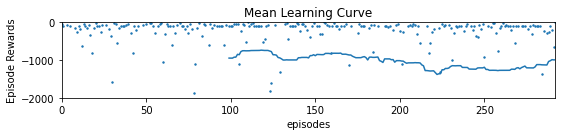

In [ ]:

plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Mean Learning Curve")
plt.ylim(-2000,0)
plt.savefig('training_env5_min20000_100km.png',dpi=300)

In [ ]:

obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
      
    display.display(plt.gcf())
    env.render()

    display.clear_output(wait=True)


AttributeError: ignored

# Env1-4 render 

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
from IPython import display
%matplotlib inline
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=10, metadata=metadata)


obs = env.reset()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
x = []
y = []
reward_list= []

with writer.saving(fig, "15000traiend_notermination_random.mp4", 100):
    for i in range(300):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        print (dones)
        x.append(obs[0])
        y.append(obs[1])
        reward_list.append(rewards)
        ax.set_xlim(0,reg_test.xmax)
        ax.set_ylim(0, reg_test.ymax)
        ax.scatter(x,y, c = reward_list, cmap = 'viridis', vmin = -1, vmax = 0)
        
        #ax.scatter(target_test.loc[0],target_test.loc[1],c = 'r')
        if dones:
          x = []
          y = []
          reward_list = []

          obs = env.reset()
        writer.grab_frame()
        ax.cla()


In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy


# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=200)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean_reward:-25.91 +/- 0.00





# Env5 render

Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached


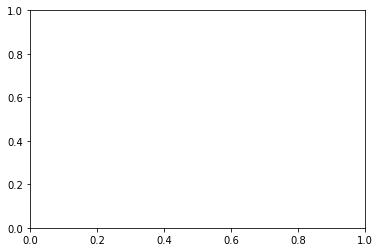

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
from IPython import display
%matplotlib inline
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=10, metadata=metadata)
env = AcousticSearchEnv5(2500,20,target_test,reciver_test,reg_test)
obs = env.reset()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

x = []
y = []
reward_list= []

x.append(env.rec_start_loc[0])
y.append(env.rec_start_loc[1])
reward_list.append(0)

with writer.saving(fig, "env5test_new_100km.mp4", 100):
    for i in range(500):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)

        x.append(x[-1] + obs[-1,0])
        y.append(y[-1]  + obs[-1,1])
        reward_list.append(rewards)
        ax.set_xlim(0,reg_test.xmax)
        ax.set_ylim(0, reg_test.ymax)
        ax.scatter(x,y, c = reward_list,vmin=-1,vmax=0,cmap ='brg' )
        ax.scatter(env.tar_start_loc[0],env.tar_start_loc[1], c = 'r')
        #ax.scatter(target_test.loc[0],target_test.loc[1],c = 'r')
        if dones:
          x = []
          y = []
          reward_list= []
          obs = env.reset()
          x.append(env.rec_start_loc[0])
          y.append(env.rec_start_loc[1])
          reward_list.append(0)

        writer.grab_frame()
        ax.cla()


In [ ]:
params = model.get_parameters()
for key, value in params.items():
  for key2, value2 in value.items():
    try:
      if not np.isfinite(value2.numpy()).all():
        print('broken')
    except:
      pass

In [ ]:

value2

In [ ]:
value




# Figure Code


In [ ]:
### set up environment ### 

np.random.seed(2021)


reg_test = Region(xmax = 25000, ymax=25000)
reg_test.add_grid_numeric(1000)
reg_test.add_flat_bathy(3000)
reg_test.add_channel_velocity()



target_test = Target(max_v=10, freq=20, source_level=190)
reciver_test = Receiver()

target_test.change_start_pos(10000,10000,30)
reciver_test.change_start_pos(5000,5000,300)

step_length = 1000 #meters 
direction_number = 16 #number of options to move (generally powers of 2)
timesteps =  50000
check_freq = 1000
noise_level = 90



plot_steps = 200
plot_timesteps = [5000,10000]

5000000


## Environment

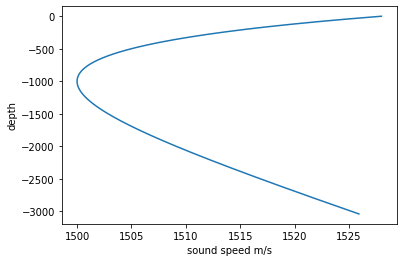

In [ ]:
reg_test.plot_ss_centre()


start interp


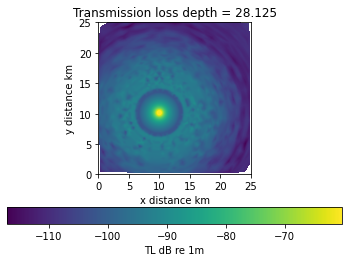

In [ ]:
environment_ex = cylinder_pyram(reciver_test,target_test,reg_test,5)
environment_ex.run_cylinder()
environment_ex.interpolate_slices(100)

environment_ex.plot_TL_slice(2)

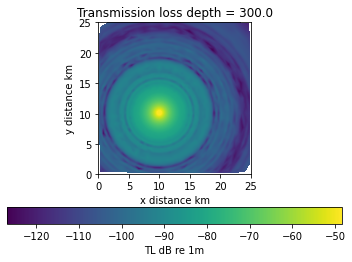

In [ ]:
environment_ex.plot_TL_slice(31)

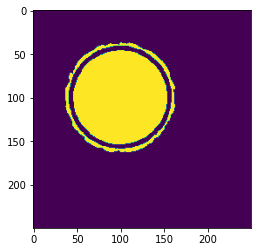

In [ ]:
SNR = 190 - environment_ex.interp_results - 90
detections = SNR > 10
plt.imshow(detections[:,:,31])

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
plt.imshow(np.rot90(environment_ex.interp_results[:,150,:]), extent=[environment_ex.Region.xmin/1000,environment_ex.Region.xmax/1000,environment_ex.Region.bathy.max()/1000,0], cmap = 'viridis_r')
plt.xlabel('x distance km')
plt.ylabel('Depth km')
plt.colorbar(orientation = 'horizontal', label = 'TL dB re 1m')


## Random start stationary source

In [ ]:
####### learn ########
np.random.seed(2021)
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

env = AcousticSearchEnv4(step_length,direction_number,target_test,reciver_test,reg_test, random = False)
env = Monitor(env, log_dir)

model = PPO(MlpPolicy, env)
#callback = SaveOnBestTrainingRewardCallback(check_freq=check_freq, log_dir=log_dir)
model.learn(total_timesteps=int(timesteps), log_interval=20)
model.save('ppo_env4_{}'.format(timesteps))
del model




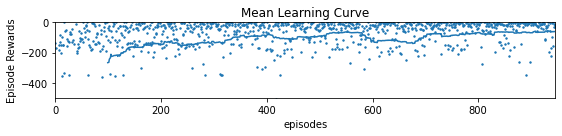

In [ ]:
###### plot ####### 

plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Mean Learning Curve")
plt.ylim(-500,0)
plt.savefig('training_env4_ICUA_R_S_50000.png',dpi=300)

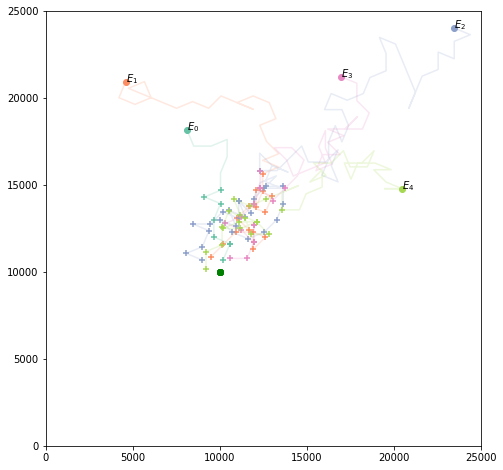

In [ ]:

### plot behaviour #### 

model = PPO.load('ppo_env4_{}'.format(timesteps))
np.random.seed(2021)
obs = env.reset()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

x = np.array([])
y = np.array([])
reward_list=  np.array([])
episode =0

n = 5 #number of episodes to plot maximum = 8
#color=iter(plt.cm.Pastel2(np.linspace(0,n/9,n)))
color=iter(plt.cm.Set2(np.linspace(0,n/9,n)))
markers = ['+','o']
while episode<n:
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)

        x = np.append(x,obs[0])
        y = np.append(y,obs[1])
        reward_list = np.append(reward_list,rewards)
        
        
        if dones:
          c = next(color)
          ax.set_xlim(0,reg_test.xmax)
          ax.set_ylim(0, reg_test.ymax)
          ax.set_aspect('equal')
          ax.plot(x,y,color = c, alpha=0.2)
          ax.scatter(x[reward_list == 0],y[reward_list == 0],  marker = markers[0],color=c)
          #ax.scatter(x[reward_list < 0],y[reward_list < 0],  marker = markers[1],color=c)
          



          ax.scatter(target_test.loc[0],target_test.loc[1],c = 'g' , marker = 'o')
          ax.scatter(x[0],y[0],color =c , marker = 'o')
          ax.text(x[0],y[0], '$E_{}$'.format(episode))

          x =  np.array([])
          y =  np.array([])
          reward_list =  np.array([])
          episode+=1
          #
          
          
          

          obs = env.reset()
          

fig.savefig('behaviour_env4_new_{}.png'.format(timesteps),dpi=300)

In [ ]:
##### plot only end points ######

np.random.seed(2021)
obs = env.reset()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

x = np.array([])
y = np.array([])
reward_list=  np.array([])
episode =0

n = 10000 #number of episodes to plot maximum = 8
#color=iter(plt.cm.Pastel2(np.linspace(0,n/9,n)))
color=iter(plt.cm.Set2(np.linspace(0,n/9,n)))
markers = ['+','o']
while episode<n:
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)

        
        
        if dones:
          x = np.append(x,obs[0])
          y = np.append(y,obs[1])
          #ax.scatter(x[reward_list < 0],y[reward_list < 0],  marker = markers[1],color=c)
          episode+=1  

          obs = env.reset()

ax.scatter(x,y, c = 'r', alpha = 0.3)
ax.scatter(target_test.loc[0],target_test.loc[1],c = 'g' , marker = 'o') 

fig.savefig('behaviour_env4_end_point_40000.png',dpi=300)


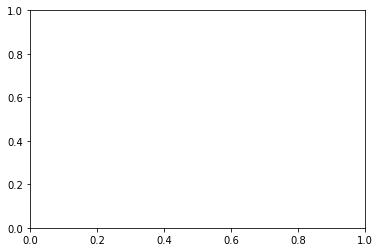

In [ ]:
#### animations ######


from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
from IPython import display
%matplotlib inline
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=10, metadata=metadata)


obs = env.reset()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
x = np.array([])
y = np.array([])
reward_list=  np.array([])
n = 5 #number of episodes to plot maximum = 8
#color=iter(plt.cm.Pastel2(np.linspace(0,n/9,n)))
color=iter(plt.cm.Set2(np.linspace(0,n/9,n+1)))
markers = ['+','o']
c = next(color)
episode = 0
with writer.saving(fig, "15000traiend_notermination_random.mp4", 100):
    while episode<n:
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        x = np.append(x,obs[0])
        y = np.append(y,obs[1])
        reward_list = np.append(reward_list,rewards)
        ax.set_xlim(0,reg_test.xmax)
        ax.set_ylim(0, reg_test.ymax)
        ax.plot(x,y,color = c, alpha=0.2)
        ax.scatter(x[reward_list == 0],y[reward_list == 0],  marker = markers[0],color=c)

        ax.scatter(target_test.loc[0],target_test.loc[1],c = 'g' , marker = 'o')
        ax.scatter(x[0],y[0],color =c , marker = 'o')
        ax.text(x[0],y[0], '$E_{}$'.format(episode))
        
        #ax.scatter(target_test.loc[0],target_test.loc[1],c = 'r')
        if dones:
          c = next(color)
          x = np.array([])
          y = np.array([])
          reward_list=  np.array([])

          obs = env.reset()
          episode+=1
        writer.grab_frame()
        
        ax.cla()
        

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
for timesteps in plot_timesteps:
  log_dir = "tmp/"
  os.makedirs(log_dir, exist_ok=True)
  env = AcousticSearchEnv4(step_length,direction_number,target_test,reciver_test,reg_test, random = False)
  env = Monitor(env, log_dir)
  model = PPO(MlpPolicy, env)
  callback = SaveOnBestTrainingRewardCallback(check_freq=check_freq, log_dir=log_dir)
  model.learn(total_timesteps=int(timesteps), callback=callback)
  obs = env.reset()
  
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot()

  x = np.array([])
  y = np.array([])
  reward_list=  np.array([])
  episode =0

  n = 5 #number of episodes to plot maximum = 8
  #color=iter(plt.cm.Pastel2(np.linspace(0,n/9,n)))
  color=iter(plt.cm.Set2(np.linspace(0,n/9,n)))
  markers = ['+','o']
  while episode<n:
          action, _states = model.predict(obs)
          obs, rewards, dones, info = env.step(action)

          x = np.append(x,obs[0])
          y = np.append(y,obs[1])
          reward_list = np.append(reward_list,rewards)
          
          
          if dones:
            c = next(color)
            ax.set_xlim(0,reg_test.xmax)
            ax.set_ylim(0, reg_test.ymax)
            ax.set_aspect('equal')
            ax.plot(x,y,color = c, alpha=0.2)
            ax.scatter(x[reward_list == 0],y[reward_list == 0],  marker = markers[0],color=c)
            #ax.scatter(x[reward_list < 0],y[reward_list < 0],  marker = markers[1],color=c)
            



            ax.scatter(target_test.loc[0],target_test.loc[1],c = 'g' , marker = 'o')
            ax.scatter(x[0],y[0],color =c , marker = 'o')
            ax.text(x[0],y[0], '$E_{}$'.format(episode))

            x =  np.array([])
            y =  np.array([])
            reward_list =  np.array([])
            episode+=1
            #
            
            
            

            obs = env.reset()
          


  fig.savefig('behaviour_env4_ICUA_R_S_{}.png'.format(timesteps),dpi=300)


## Random Start Random Source

##Random Start Random Source (memory)

In [ ]:
np.random.seed(2021)
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

env = AcousticSearchEnv5(step_length,direction_number,target_test,reciver_test,reg_test)
env = Monitor(env, log_dir)

model = PPO(MlpPolicy, env)

model.learn(total_timesteps=int(timesteps), log_interval=20)
model.save('ppo_env5_{}'.format(timesteps))
del model


Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps 

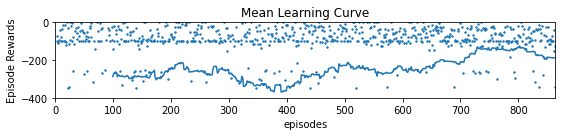

In [ ]:
###### plot ####### 

plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Mean Learning Curve")
plt.ylim(-400,0)
plt.savefig('training_env5_ICUA_R_R_50000.png',dpi=300)

Max Steps reached


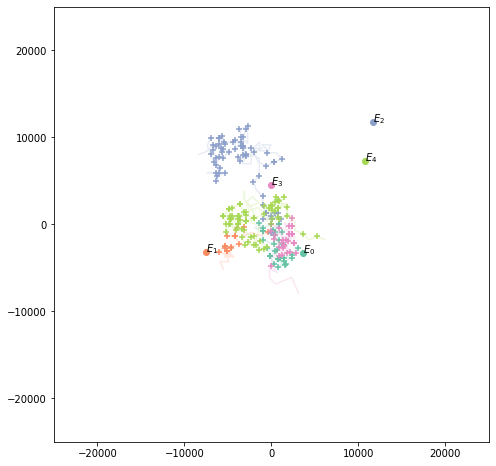

In [ ]:
### plot behaviour #### 
obs = env.reset()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

x = np.array([])
y = np.array([])
reward_list=  np.array([])
episode =0

n = 5 #number of episodes to plot maximum = 8
#color=iter(plt.cm.Pastel2(np.linspace(0,n/9,n)))
color=iter(plt.cm.Set2(np.linspace(0,n/9,n)))
markers = ['+','o']

#x=np.append(x,env.rec_start_loc[0])
#y=np.append(y,env.rec_start_loc[1])
#reward_list=np.append(reward_list,0)


x=np.append(x,0)
y=np.append(y,0)
reward_list=np.append(reward_list,0)


while episode<n:
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)

        
        x= np.append(x,x[-1] + obs[-1,0])
        y = np.append(y,y[-1]  + obs[-1,1])
        reward_list = np.append(reward_list,rewards)
        
        
        if dones:
          c = next(color)
          ax.set_xlim(-reg_test.xmax,reg_test.xmax)
          ax.set_ylim(-reg_test.ymax, reg_test.ymax)
          ax.set_aspect('equal')
          ax.plot(x,y,color = c, alpha=0.2)
          ax.scatter(x[reward_list == 0],y[reward_list == 0],  marker = markers[0],color=c)
          #ax.scatter(x[reward_list < 0],y[reward_list < 0],  marker = markers[1],color=c)
          



          ax.scatter(target_test.loc[0] - env.rec_start_loc[0],target_test.loc[1] - env.rec_start_loc[1] ,color = c , marker = 'o')
          ax.text(target_test.loc[0]- env.rec_start_loc[0],target_test.loc[1]- env.rec_start_loc[1], '$E_{}$'.format(episode))

          #ax.scatter(x[0],y[0],color =c , marker = 'o')
          #ax.text(x[0],y[0], '$E_{}$'.format(episode))

          x =  np.array([])
          y =  np.array([])
          reward_list =  np.array([])

                    
          #x=np.append(x,env.rec_start_loc[0])
          #y=np.append(y,env.rec_start_loc[1])
          #reward_list=np.append(reward_list,0)



          x=np.append(x,0)
          y=np.append(y,0)
          reward_list=np.append(reward_list,0)


          episode+=1
          #
          
          
          

          obs = env.reset()
          


fig.savefig('behaviour_env5_ICUA_R_S_40000.png',dpi=300)

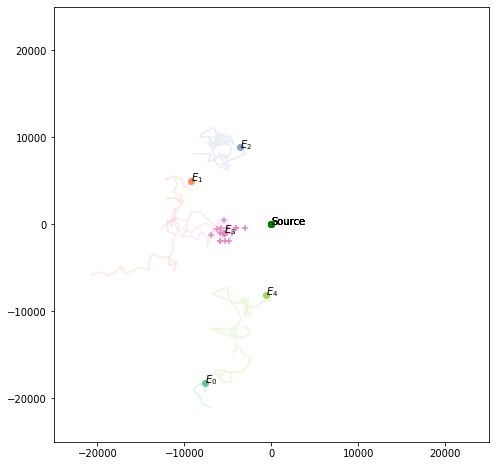

In [ ]:
### plot behaviour #### 


model = PPO.load('ppo_env5_{}'.format(timesteps))


obs = env.reset()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

x = np.array([])
y = np.array([])
reward_list=  np.array([])
episode =0

n = 5 #number of episodes to plot maximum = 8
#color=iter(plt.cm.Pastel2(np.linspace(0,n/9,n)))
color=iter(plt.cm.Set2(np.linspace(0,n/9,n)))
markers = ['+','o']

#x=np.append(x,env.rec_start_loc[0])
#y=np.append(y,env.rec_start_loc[1])
#reward_list=np.append(reward_list,0)


x=np.append(x,env.rec_start_loc[0]- target_test.loc[0])
y=np.append(y,env.rec_start_loc[1]- target_test.loc[1])
reward_list=np.append(reward_list,0)


while episode<n:
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)

        
        x= np.append(x,x[-1] + obs[-1,0] )
        y = np.append(y,y[-1]  + obs[-1,1])
        reward_list = np.append(reward_list,rewards)
        
        
        if dones:
          c = next(color)
          ax.set_xlim(-reg_test.xmax,reg_test.xmax)
          ax.set_ylim(-reg_test.ymax, reg_test.ymax)
          ax.set_aspect('equal')
          ax.plot(x,y,color = c, alpha=0.2)
          ax.scatter(x[reward_list == 0],y[reward_list == 0],  marker = markers[0],color=c)
          #ax.scatter(x[reward_list < 0],y[reward_list < 0],  marker = markers[1],color=c)
          



          ax.scatter(env.rec_start_loc[0]- target_test.loc[0] ,env.rec_start_loc[1]- target_test.loc[1] ,color = c , marker = 'o')
          ax.text(env.rec_start_loc[0]- target_test.loc[0],env.rec_start_loc[1]- target_test.loc[1], '$E_{}$'.format(episode))

          ax.scatter(0,0,color ='g' , marker = 'o')
          ax.text(0,0, 'Source')

          x =  np.array([])
          y =  np.array([])
          reward_list =  np.array([])

                    
          #x=np.append(x,env.rec_start_loc[0])
          #y=np.append(y,env.rec_start_loc[1])
          #reward_list=np.append(reward_list,0)


          obs = env.reset()
          x=np.append(x,env.rec_start_loc[0]- target_test.loc[0])
          y=np.append(y,env.rec_start_loc[1]- target_test.loc[1])
          reward_list=np.append(reward_list,0)


          episode+=1
          #
          
          
          

          
          


fig.savefig('behaviour_env5_ICUA_R_S_40000.png',dpi=300)

# Load + Plot

In [ ]:
### set up environment ### 

np.random.seed(2021)


reg_test = Region(xmax = 25000, ymax=25000)
reg_test.add_grid_numeric(1000)
reg_test.add_flat_bathy(3000)
reg_test.add_channel_velocity()



target_test = Target(max_v=10, freq=20, source_level=190)
reciver_test = Receiver()

target_test.change_start_pos(10000,10000,30)
reciver_test.change_start_pos(5000,5000,300)

step_length = 1000 #meters 
direction_number = 16 #number of options to move (generally powers of 2)
timesteps =  50000
check_freq = 1000
noise_level = 90



plot_steps = 200
plot_timesteps = [5000,10000]

In [ ]:
#load models + env

env_4_model = PPO.load('ppo_env4_50000')
env_5_model = PPO.load('ppo_env5_50000')

env_4 = AcousticSearchEnv4(step_length,direction_number,target_test,reciver_test,reg_test, random = False)
env_5 = AcousticSearchEnv5(step_length,direction_number,target_test,reciver_test,reg_test)

env_4_rand = AcousticSearchEnv4(step_length,direction_number,target_test,reciver_test,reg_test, random = True)


In [ ]:
### calculate stats on N steps 

def model_stats(env,model,steps):

  ep_length = [0]
  ep_detection = [0]
  ep_reward = [0]
  obs = env.reset()
  
  

  for i in range(steps):
      action, _states = model.predict(obs)
      obs, rewards, dones, info = env.step(action)

      ep_length[-1] +=  1
      ep_reward[-1] += rewards

      if rewards == 0:
        ep_detection[-1] += 1
      


      if dones:
        ep_length.append(0)
        ep_detection.append(0)
        ep_reward.append(0)
        obs = env.reset()
  
  ep_length = np.array(ep_length)
  ep_detection = np.array(ep_detection)
  ep_reward = np.array(ep_reward)

  stats = {
      'lengths' : {
          'data' : ep_length,
      'mean' : np.mean(ep_length),
      'std'  : np.std(ep_length),
      'hist' : np.histogram(ep_length)},

      'detection' : {
          'data' : ep_detection,
      'mean' : np.mean(ep_detection),
      'std'  : np.std(ep_detection),
      'hist' : np.histogram(ep_detection)},

      'reward' : {
          'data' : ep_reward,
      'mean' : np.mean(ep_reward),
      'std'  : np.std(ep_reward),
      'hist' : np.histogram(ep_reward)},

  }

  return stats
 
        

In [ ]:

##### calculate stats in trained region #########


eval_N = 20000

env_4_stats_norm = model_stats(env_4,env_4_model,eval_N)
env_5_stats_norm = model_stats(env_5,env_5_model,eval_N)

Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps 

In [ ]:
env_4_stats_rand = model_stats(env_4_rand,env_4_model,eval_N)

In [ ]:
import pickle


env_4_norm_file = open("env_4_norm_stats.pkl", "wb")
env_4_rand_file = open("env_4_rand_stats.pkl", "wb")
env_5_norm_file = open("env_5_norm_stats.pkl", "wb")

pickle.dump(env_4_stats_norm, env_4_norm_file)
pickle.dump(env_4_stats_rand, env_4_rand_file)
pickle.dump(env_5_stats_norm, env_5_norm_file)


env_4_norm_file.close()
env_5_norm_file.close()
env_4_rand_file.close()

In [ ]:
env_4_stats_norm['lengths']

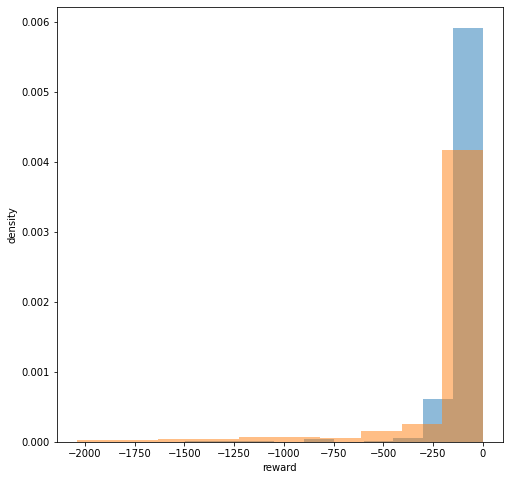

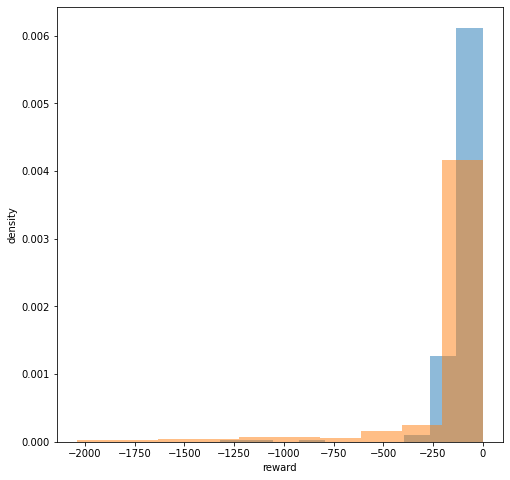

In [ ]:
##### COMPARISONS ####

## reward ###

fig= plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.hist(env_4_stats_norm['reward']['data'], density=True, alpha = 0.5, bins = 10)
ax.hist(env_5_stats_norm['reward']['data'], density=True, alpha = 0.5, bins = 10)

ax.set_ylabel('density')
ax.set_xlabel('reward')
fig.savefig('reward_histogram_50000_norm.png',dpi=300)


fig= plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.hist(env_4_stats_rand['reward']['data'], density=True, alpha = 0.5, bins = 10)
ax.hist(env_5_stats_norm['reward']['data'], density=True, alpha = 0.5, bins = 10)

ax.set_ylabel('density')
ax.set_xlabel('reward')
fig.savefig('reward_histogram_50000_rand.png',dpi=300)





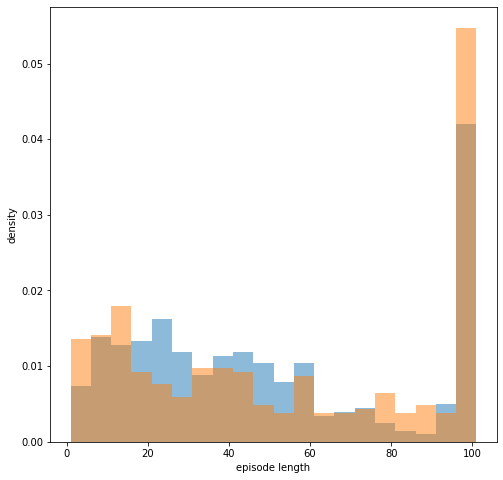

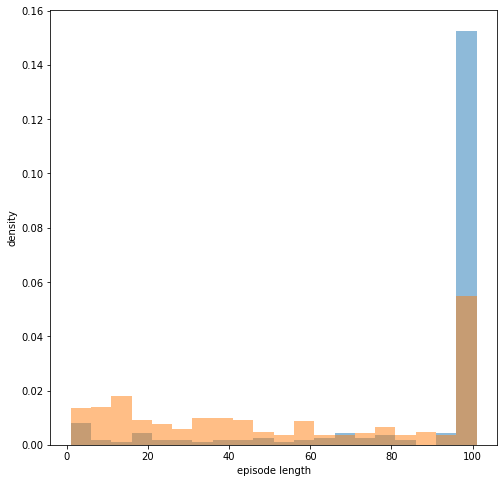

In [ ]:
## length ###

fig= plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.hist(env_4_stats_norm['lengths']['data'], density=True, alpha = 0.5, bins = 20)
ax.hist(env_5_stats_norm['lengths']['data'], density=True, alpha = 0.5, bins = 20)

ax.set_ylabel('density')
ax.set_xlabel('episode length')
fig.savefig('length_histogram_50000_norm.png',dpi=300)


fig= plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.hist(env_4_stats_rand['lengths']['data'], density=True, alpha = 0.5, bins = 20)
ax.hist(env_5_stats_norm['lengths']['data'], density=True, alpha = 0.5, bins = 20)

ax.set_ylabel('density')
ax.set_xlabel('episode length')
fig.savefig('length_histogram_50000_rand.png',dpi=300)




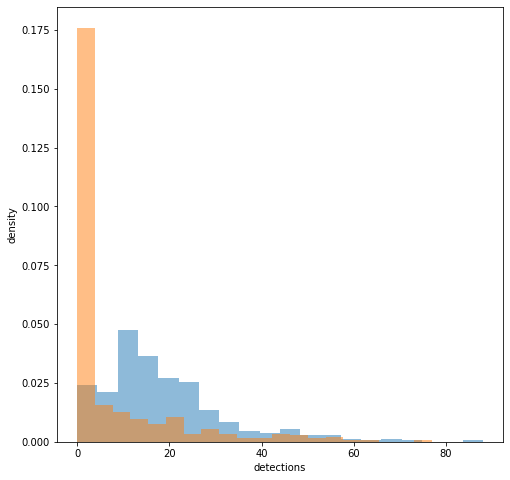

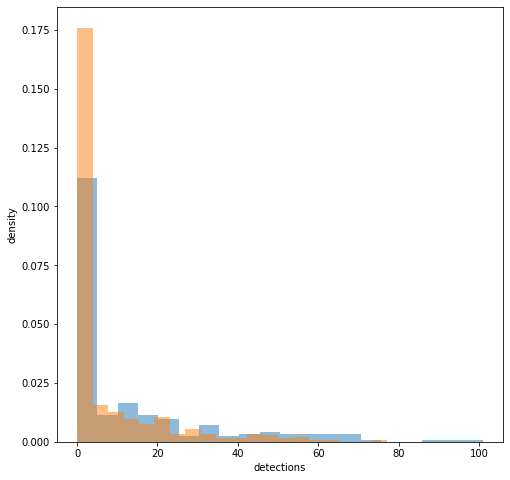

In [ ]:
## detections ###

fig= plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.hist(env_4_stats_norm['detection']['data'], density=True, alpha = 0.5, bins = 20)
ax.hist(env_5_stats_norm['detection']['data'], density=True, alpha = 0.5, bins = 20)

ax.set_ylabel('density')
ax.set_xlabel('detections')
fig.savefig('detection_histogram_50000_norm.png',dpi=300)

fig= plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.hist(env_4_stats_rand['detection']['data'], density=True, alpha = 0.5, bins = 20)
ax.hist(env_5_stats_norm['detection']['data'], density=True, alpha = 0.5, bins = 20)

ax.set_ylabel('density')
ax.set_xlabel('detections')
fig.savefig('detection_histogram_50000_rand.png',dpi=300)


(-100.0, 0.0)

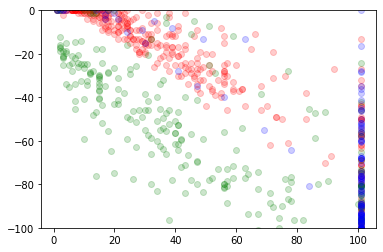

In [ ]:
plt.scatter(env_4_stats_norm['lengths']['data'],env_4_stats_norm['reward']['data'], c = 'r', alpha = 0.2)
plt.scatter(env_5_stats_norm['lengths']['data'],env_5_stats_norm['reward']['data'], c = 'g', alpha = 0.2)
plt.scatter(env_4_stats_rand['lengths']['data'],env_4_stats_rand['reward']['data'], c = 'b', alpha = 0.2)
plt.ylim(-100,0)

In [ ]:
##### new environment #####



reg_test = Region(xmax = 25000, ymax=25000)
reg_test.add_grid_numeric(1000)
reg_test.add_flat_bathy(2000)

reg_test.add_channel_velocity(h= 200, z0 = 700)



target_test = Target(max_v=10, freq=20, source_level=190)
reciver_test = Receiver()

target_test.change_start_pos(20000,20000,30)
reciver_test.change_start_pos(5000,5000,300)

step_length = 1000 #meters 
direction_number = 16 #number of options to move (generally powers of 2)
timesteps =  50000
check_freq = 1000
noise_level = 90


env_4_new = AcousticSearchEnv4(step_length,direction_number,target_test,reciver_test,reg_test, random = False)
env_5_new = AcousticSearchEnv5(step_length,direction_number,target_test,reciver_test,reg_test)

env_4_rand_new = AcousticSearchEnv4(step_length,direction_number,target_test,reciver_test,reg_test, random = True)


In [ ]:

eval_N = 1000

env_4_stats_norm_new = model_stats(env_4_new,env_4_model,eval_N)
env_5_stats_norm_new = model_stats(env_5_new,env_5_model,eval_N)
env_4_stats_rand_new = model_stats(env_4_rand_new ,env_4_model,eval_N)



Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps reached
Max Steps 

In [ ]:
class AcousticSearchEnv3(gym.Env):
  """Custom Environment that follows gym interface
  env 3 introduces the agent and acoustic environment for static targets"""
  metadata = {'render.modes': ['human']}

  def __init__(self, move_length, move_directions, TAR: Target, REC: Receiver, REG: Region):
    super(AcousticSearchEnv3, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
   
    
    #here we will use forwards back etc.. 
    high = np.array(
            [
               10000,10000,10000
            ],
            dtype=np.float32,
        )
    # observation space, current position + signal
    self.observation_space =spaces.Box(-high, high, dtype=np.float32) #scale everything relative to a 0-1 observation area
    self.action_space = spaces.Discrete(move_directions + 1) #set action space to be 4 directions  + stationary 
    #set the move length 

    self.move_length = move_length
    self.move_angles = np.linspace(0,2*np.pi,move_directions + 1)
    self.REC = REC
    self.TAR = TAR
    self.REG = REG
    self.rec_start_loc = REC.loc
    self.tar_start_loc = TAR.loc



  def _take_action(self,action):
    if action <1:
      
      pass
    
    else:
      #move forward 
      x_move =  self.move_length * np.cos(self.move_angles[action-1])
      y_move =  self.move_length * np.sin(self.move_angles[action-1])
      self.REC.change_start_pos(self.REC.loc[0] + x_move,self.REC.loc[1] + y_move,self.REC.loc[-1])



    



    



  def _next_observation(self):
    obs = self.REC.loc
    return obs


  def step(self, action):
    self._take_action(action)
    self.current_step += 1
    reward = -1 #penalise each extra step
    #reward = float(- (self.x - self.target_x)**2 -  (self.y - self.target_y)**2)

    ##### simulation for reward #######
    r_valid = (self.REG.xmin-1 <= self.REC.loc[0] <= self.REG.xmax +1) and (self.REG.ymin -1 <= self.REC.loc[1] <= self.REG.ymax +1)
    if r_valid:
      simulation = depth_range_pyram(self.REC,self.TAR,self.REG)
      try:
        simulation.setup_run(self.REG)
        simulation.run_pyram()
        transmission_loss = simulation.get_reciever_TL()
        SNR = self.TAR.source_level - transmission_loss - 95

        #### simple detection (threshold above 10dB)
        detection = SNR > 10
      except:
        detection = False

      #### set reward to high SNR for now 

      reward += int(detection) 
      x_done = abs(self.REC.loc[0] - self.TAR.loc[0]) <= self.move_length 
      y_done = abs(self.REC.loc[1] - self.TAR.loc[1]) <= self.move_length 
      done = False
      #done = bool(x_done and y_done)
    else:
      reward = -100
      done = True



    obs = self._next_observation()


    #set max steps
    if self.current_step > 100:
      done = True
    return obs, reward, done, {}
    # Execute one time step within the environment
    ...
  def reset(self):

    #reset to random start location for reciever

    self.current_step = 0
    #self.REC.change_start_pos(*self.rec_start_loc)
    self.REC.change_start_pos(np.random.random()*self.REG.xmax, np.random.random()*self.REG.ymax,self.rec_start_loc[-1])
    #self.TAR.change_start_pos(*self.tar_start_loc)

    self.TAR.change_start_pos(np.random.random()*self.REG.xmax, np.random.random()*self.REG.ymax,self.tar_start_loc[-1])

    #target starts at random point
    #self.target_x = np.random.random(size=1)
    #self.target_y = np.random.random(size=1)

    #target starts at top right


    return self._next_observation()

    # Reset the state of the environment to an initial state
    ...
  def render(self, mode='human', close=False):

    plt.scatter(self.x,self.y, label ='agent')
    plt.scatter(self.target_x,self.target_y, label = 'target')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.show(block=False)
   





In [ ]:
class AcousticSearchEnv2(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, move_length, move_directions):
    super(AcousticSearchEnv2, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
   
    
    #here we will use forwards back etc.. 
    high = np.array(
            [
               1,1
            ],
            dtype=np.float32,
        )
    # observation space, current position + signal
    self.observation_space =spaces.Box(-high, high, dtype=np.float32) #scale everything relative to a 0-1 observation area
    self.action_space = spaces.Discrete(move_directions + 1) #set action space to be 4 directions  + stationary 
    #set the move length 

    self.move_length = move_length
    self.move_angles = np.linspace(0,2*np.pi,move_directions + 1)


  def _take_action(self,action):
    if action <1:
      
      pass
    
    else:
      #move forward 
      self.x+= self.move_length * np.cos(self.move_angles[action-1])
      self.y+= self.move_length * np.sin(self.move_angles[action-1])

    



    



  def _next_observation(self):
    obs = np.array([self.x,self.y])
    return obs


  def step(self, action):
    self._take_action(action)
    self.current_step += 1

    reward = float(- (self.x - self.target_x)**2 -  (self.y - self.target_y)**2)
    obs = self._next_observation()
    x_done = abs(self.x - self.target_x) <= self.move_length 
    y_done = abs(self.y - self.target_y) <= self.move_length 

    done = bool(x_done and y_done)

    #set max steps
    if self.current_step > 100:
      done = True
    return obs, reward, done, {}
    # Execute one time step within the environment
    ...
  def reset(self):
    self.x =  0
    self.y = 0
    self.current_step = 0

    #target starts at random point
    #self.target_x = np.random.random(size=1)
    #self.target_y = np.random.random(size=1)

    #target starts at top right
    self.target_x = 1
    self.target_y = -1

    return self._next_observation()

    # Reset the state of the environment to an initial state
    ...
  def render(self, mode='human', close=False):

    plt.scatter(self.x,self.y, label ='agent')
    plt.scatter(self.target_x,self.target_y, label = 'target')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.show(block=False)
   



